In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
# Read the file into a dataframe 
df = pd.read_csv("Synthetic Fraud Detection Dataset.csv")
df.head()

,Unnamed: 0,step,type,branch,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,unusuallogin,isFlaggedFraud,Acct type,Date of transaction,Time of day,isFraud
0,0,1,PAYMENT,Indonesia,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,9,0,Current,3/1/18,Morning,0.0
1,1,1,PAYMENT,India,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,10,0,Savings,5/1/18,Morning,0.0
2,2,1,TRANSFER,India,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,2,0,Current,7/1/18,Morning,1.0
3,3,1,CASH_OUT,Australia,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,Current,6/1/18,Afternoon,1.0
4,4,1,PAYMENT,Australia,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,17,0,Current,6/1/18,Morning,0.0


In [3]:
# Check the shape of the dataframe
df.shape 

(10127, 17)

# Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           10127 non-null  int64  
 1   step                 10127 non-null  int64  
 2   type                 10123 non-null  object 
 3   branch               10127 non-null  object 
 4   amount               10125 non-null  float64
 5   nameOrig             10121 non-null  object 
 6   oldbalanceOrg        10125 non-null  float64
 7   newbalanceOrig       10127 non-null  float64
 8   nameDest             10121 non-null  object 
 9   oldbalanceDest       10126 non-null  float64
 10  newbalanceDest       10125 non-null  float64
 11  unusuallogin         10127 non-null  int64  
 12  isFlaggedFraud       10127 non-null  int64  
 13  Acct type            10117 non-null  object 
 14  Date of transaction  10120 non-null  object 
 15  Time of day          10125 non-null 

In [5]:
# Drop columns
df.drop(columns=['step', 'Unnamed: 0'], inplace=True)

In [6]:
# Convert 'isFlaggedFraud' and 'isFraud' columns to categorical
df['isFlaggedFraud'] = df['isFlaggedFraud'].astype('category')
df['isFraud'] = df['isFraud'].astype('category')

In [7]:
# Now let's check for null values again
df.isnull().sum()

type                    4
branch                  0
amount                  2
nameOrig                6
oldbalanceOrg           2
newbalanceOrig          0
nameDest                6
oldbalanceDest          1
newbalanceDest          2
unusuallogin            0
isFlaggedFraud          0
Acct type              10
Date of transaction     7
Time of day             2
isFraud                 2
dtype: int64

In [8]:
# Drop rows with missing values
df.dropna(inplace=True)

# Check if there are any remaining missing values
print(df.isnull().sum())

type                   0
branch                 0
amount                 0
nameOrig               0
oldbalanceOrg          0
newbalanceOrig         0
nameDest               0
oldbalanceDest         0
newbalanceDest         0
unusuallogin           0
isFlaggedFraud         0
Acct type              0
Date of transaction    0
Time of day            0
isFraud                0
dtype: int64


In [9]:
# Removing Duplicates
duplicate_rows = df.duplicated().sum()
print("Duplicate Rows:", duplicate_rows)

Duplicate Rows: 0


In [52]:
#Checking unique values in isFraud column
unique_values = df['isFraud'].unique()
print("Unique values in 'isFraud' column:", unique_values)

count_fraud = df[df['isFraud'] == 1].shape[0]
print("Number of rows where 'is Fraud' is 1:", count_fraud)

Unique values in 'isFraud' column: [0.0, 1.0]
Categories (2, float64): [0.0, 1.0]
Number of rows where 'is Fraud' is 1: 68


# Data Consistency

In [11]:
# Convert 'Date of transaction' to datetime format
df['Date of transaction'] = pd.to_datetime(df['Date of transaction'])

In [12]:
# Assuming the dates have been parsed already
unique_dates = df['Date of transaction'].dt.date.unique()
# Printing unique dates
print(unique_dates)


[datetime.date(2018, 3, 1) datetime.date(2018, 5, 1)
 datetime.date(2018, 7, 1) datetime.date(2018, 6, 1)
 datetime.date(2018, 8, 1) datetime.date(2018, 10, 1)
 datetime.date(2018, 11, 1) datetime.date(2018, 1, 13)
 datetime.date(2018, 1, 16) datetime.date(2018, 1, 19)
 datetime.date(2018, 1, 25) datetime.date(2018, 12, 1)
 datetime.date(2018, 9, 1) datetime.date(2018, 2, 1)]


In [13]:
df.head()

,type,branch,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,unusuallogin,isFlaggedFraud,Acct type,Date of transaction,Time of day,isFraud
0,PAYMENT,Indonesia,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,9,0,Current,2018-03-01,Morning,0.0
1,PAYMENT,India,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,10,0,Savings,2018-05-01,Morning,0.0
2,TRANSFER,India,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,2,0,Current,2018-07-01,Morning,1.0
3,CASH_OUT,Australia,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,Current,2018-06-01,Afternoon,1.0
4,PAYMENT,Australia,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,17,0,Current,2018-06-01,Morning,0.0


In [14]:
df.branch.unique()

array(['Indonesia', 'India', 'Australia', 'China', 'Japon',
       'Corea del Sur', 'Singapur', 'Turquia', 'Mongolia',
       'Estados Unidos', 'Nigeria', 'Republica Democratica del Congo',
       'Senegal', 'Marruecos', 'Alemania', 'Paises Bajos', 'Reino Unido',
       'Francia', 'Guatemala', 'El Salvador', 'Panama',
       'Republica Dominicana', 'Venezuela', 'Colombia', 'Honduras',
       'Brasil', 'Mexico', 'Cuba', 'Peru', 'Nicaragua', 'Argentina',
       'Ecuador', 'Angola', 'Sudan', 'Somalia', 'Costa de Marfil',
       'Egipto', 'Italia', 'Espana', 'Suecia', 'Austria', 'Canada',
       'Madagascar', 'Argelia', 'Liberia', 'Zambia', 'Niger', 'SudAfrica',
       'Mozambique', 'Tanzania', 'Ruanda', 'Israel', 'Nueva Zelanda',
       'Banglades', 'Tailandia', 'Irak', 'Arabia Saudi', 'Filipinas',
       'Kazajistan', 'Iran', 'Myanmar (Birmania)', 'Uzbekistan', 'Benin',
       'Camerun', 'Kenia', 'Togo', 'Ucrania', 'Polonia', 'Portugal',
       'Rumania', 'Trinidad y Tobago', 'Afganistan

# Exploartory Data Analysis

In [15]:
stat = df.describe().transpose()
stat

,count,mean,std,min,25%,50%,75%,max
amount,10088.0,1.049915e+05,2.710144e+05,2.39,4392.4075,12818.75,114409.0350,10000000.0
oldbalanceOrg,10088.0,8.867322e+05,2.127829e+06,0.00,135.5000,21394.00,173205.9850,12900000.0
newbalanceOrig,10088.0,9.077738e+05,2.173468e+06,0.00,0.0000,10283.01,172150.9075,13000000.0
oldbalanceDest,10088.0,9.345118e+05,2.680995e+06,0.00,0.0000,0.00,281882.8550,19500000.0
newbalanceDest,10088.0,1.108236e+06,3.046412e+06,0.00,0.0000,0.00,252373.5600,22600000.0
unusuallogin,10088.0,1.051527e+01,5.809692e+00,0.00,6.0000,10.00,16.0000,20.0


## Distribution of Transaction Amounts

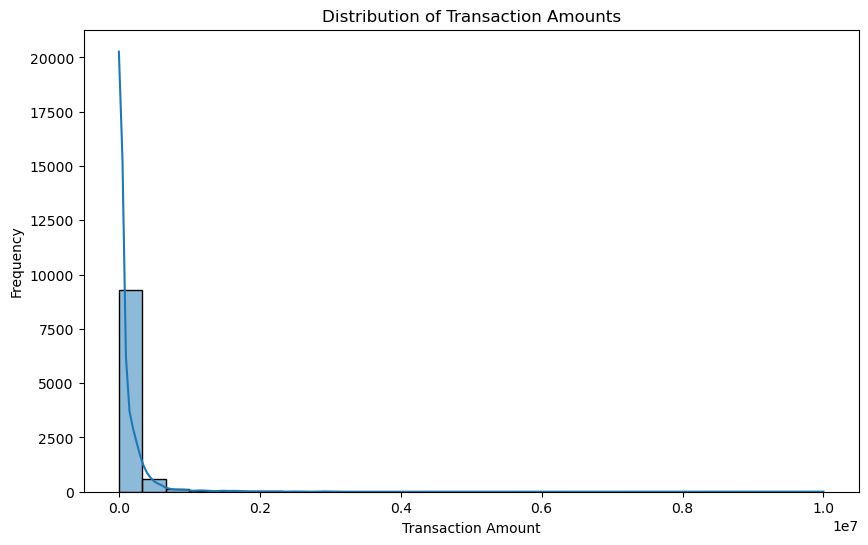

In [16]:
# Distribution of Transaction Amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], bins=30, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

The distribution of the transaction amount shows a right-skewed distribution. This distribution suggests that the data set contains mostly smaller-value transactions, with relatively fewer larger-value transactions.

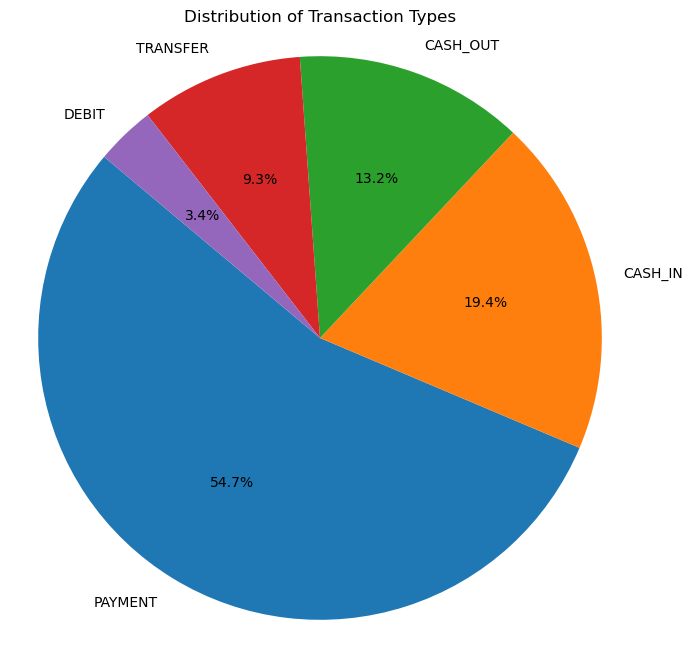

In [17]:
# Calculate the count of each transaction type
transaction_type_counts = df['type'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(transaction_type_counts, labels=transaction_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Transaction Types')
plt.axis('equal')
plt.show()


The pie chart provides a clear breakdown of the distribution of different transaction types within the data set. This provides valuable insights into the nature of the transactions being processed, highlighting the predominance of payment-related activity and the relative frequencies of cash-based inflows and outflows compared to other transaction types.

The majority of transactions fall under the 'PAYMENT' category, constituting 54.7% of the total transactions. This indicates that the majority of activity involves the transfer of funds as payment for goods or services.

Followed by CASH_IN transactions, accounting for 19.4% of the total. These transactions represent instances where cash is being deposited or added to an account, such as through ATM deposits or branch visits. Following this, CASH_OUT transactions make up 13.2% of the total. These transactions involve the withdrawal of cash from an account, whether through ATM withdrawals, bank branch transactions, or other cash removal activities.

Debit transactions, which could include direct debit payments or other account-based debits, comprise 9.3% of the total. Finally, TRANSFER transactions, which may involve the movement of funds between accounts or to other parties, make up the smallest portion at 3.4% of the overall transaction volume.

Understanding the distribution of transaction types is crucial for several aspects of this analysis:

**Fraud Detection:** Certain transaction types may be more susceptible to fraudulent activities. For example, 'TRANSFER' and 'CASH_OUT' transactions are often associated with fraudulent behavior. By knowing the distribution of transaction types, we can focus fraud detection efforts on the transaction types that are more likely to be fraudulent, thereby improving the effectiveness of fraud prevention measures.


**Transaction Monitoring:** Monitoring transaction types allows financial institutions to ensure compliance with regulations and detect suspicious activities. For instance, large volumes of 'TRANSFER' transactions may warrant closer scrutiny to identify potential money laundering schemes. By analyzing the distribution of transaction types over time, we can identify trends or anomalies that may require further investigation.

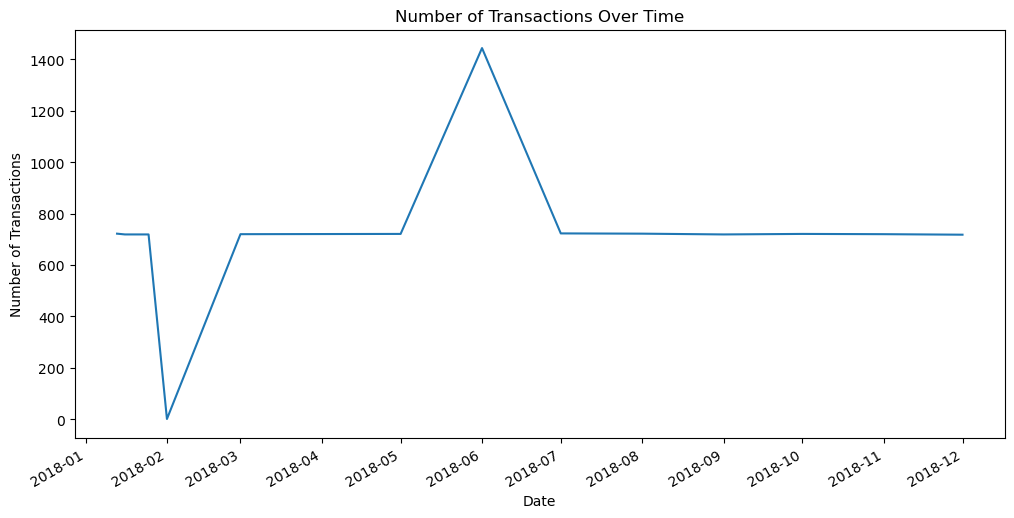

In [18]:
# Trend Analysis
plt.figure(figsize=(12, 6))
df['Date of transaction'].value_counts().plot(kind='line')
plt.title('Number of Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()


This graph displays the Number of Transactions over time. By observing the fluctuations in transaction volumes across different time periods, we can discern patterns and trends that are crucial for understanding the underlying dynamics of the financial data. The graph reveals notable variations in transaction volumes throughout the year, with a particularly pronounced spike in activity observed around June 2018. This spike may indicate a period of heightened financial activity, potentially driven by seasonal factors, economic events, or other external influences. Following this peak, the graph shows a gradual normalization of transaction volumes to a more stable and sustainable level. Understanding these fluctuations in transaction activity is essential for various reasons, including times of unusual activities, fraud detection, customer behavior analysis, and strategic decision-making within financial institutions. By contextualizing the trend analysis within our broader analysis framework, we can leverage these insights to make informed decisions and derive actionable recommendations for mitigating risks.

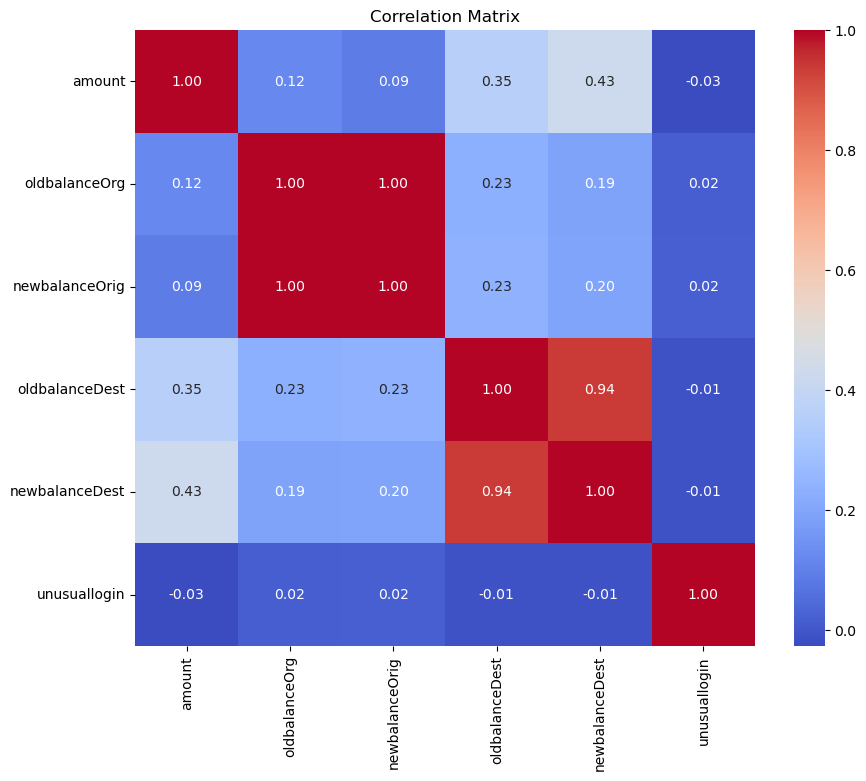

In [19]:
# Correlation Analysis
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

This correlation matrix provides a comprehensive view of the relationships between all the variables in the dataset. It can be used to identify which variables are strongly correlated, either positively or negatively, and which ones have little to no correlation. We see a high positive correlation between a person's old balance and new balance.

The correlation coefficients of unusal login show weak and negligible correlation other variables in the dataset.The correlation are all close to 0, indicating that unusual login events do not seem to have a meaningful relationship with the amounts, balances, or other time-based variables. This means that changes in unusual login are unlikely to be associated with consistent or predictable changes in the other variables.
This may complicate fraud detection efforts and limits our ability to draw direct conclusions or make predictions based solely on login patterns. However, it highlights the complexity and multifaceted nature of the financial industry in fraud detection efforts. 



# Anolmaly Detection

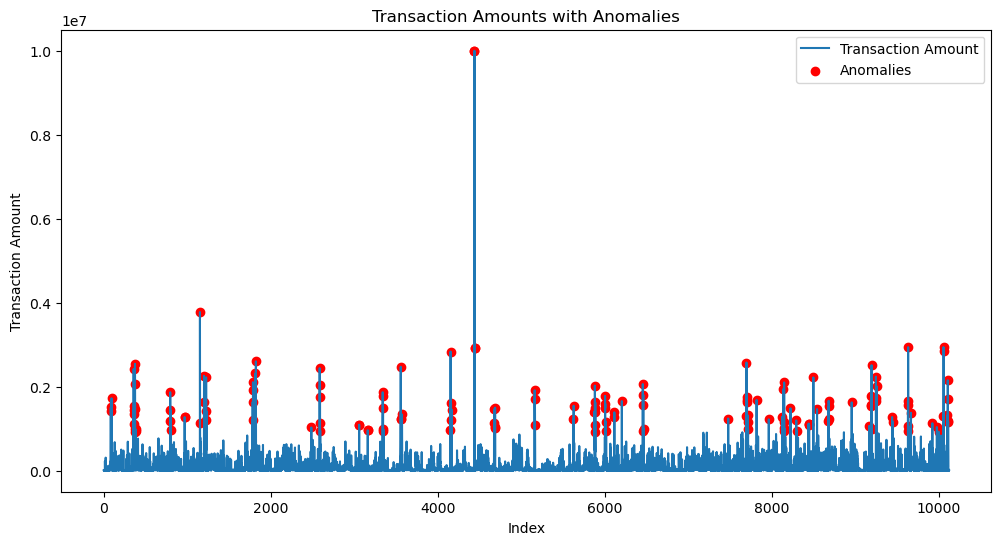

Anomalies:


,type,branch,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,unusuallogin,isFlaggedFraud,Acct type,Date of transaction,Time of day,isFraud,z_score
85,TRANSFER,Republica Dominicana,1505626.01,C926859124,0.0,0.0,C665576141,29031.00,5515763.34,18,0,Current,2018-05-01,Morning,0.0,5.168118
89,TRANSFER,Mexico,1429051.47,C1520267010,0.0,0.0,C1590550415,2041543.62,19200000.00,2,0,Savings,2018-08-01,Morning,0.0,4.885570
94,TRANSFER,Brasil,1724887.05,C1495608502,0.0,0.0,C1590550415,3470595.10,19200000.00,7,0,Current,2018-01-13,Afternoon,0.0,5.977157
358,TRANSFER,Guatemala,1538200.39,C476579021,0.0,0.0,C1590550415,6977445.38,19200000.00,20,0,Current,2018-11-01,Night,0.0,5.288312
359,TRANSFER,Brasil,2421578.09,C106297322,0.0,0.0,C1590550415,8515645.77,19200000.00,7,0,Current,2018-12-01,Night,0.0,8.547835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10106,TRANSFER,Cuba,1315556.51,C1653980726,38960.2,0.0,C257999182,2324423.73,15000000.00,19,0,Savings,2018-01-19,Night,0.0,4.466792
10107,TRANSFER,Barbados,1154104.37,C234458729,0.0,0.0,C766681183,13100000.00,17400000.00,1,0,Savings,2018-01-25,Night,0.0,3.871059
10109,TRANSFER,Honduras,1719356.16,C14302379,0.0,0.0,C1636786811,7082993.39,14500000.00,10,0,Current,2018-05-01,Morning,0.0,5.956748
10110,TRANSFER,Republica Dominicana,2153550.39,C1332823688,0.0,0.0,C935808590,12700000.00,18400000.00,5,0,Savings,2018-07-01,Afternoon,0.0,7.558856


In [20]:
# Calculate Z-score for transaction amounts
mean_amount = df['amount'].mean()
std_amount = df['amount'].std()
df['z_score'] = (df['amount'] - mean_amount) / std_amount

# Define a threshold for Z-score to identify anomalies
z_score_threshold = 3

# Identify anomalies based on Z-score
anomalies = df[df['z_score'].abs() > z_score_threshold]

# Visualize transaction amounts and anomalies
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['amount'], label='Transaction Amount')
plt.scatter(anomalies.index, anomalies['amount'], color='red', label='Anomalies')
plt.title('Transaction Amounts with Anomalies')
plt.xlabel('Index')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()

# Display identified anomalies
print("Anomalies:")
anomalies

The red dots, which are overlaid on the blue line, highlight the instances where the Transaction Amounts deviate significantly from the typical values. These red dots can be interpreted as anomalies or outliers in the data.

Some key observations from this plot:

* There are several pronounced spikes in the Transaction Amounts, some of which are accompanied by red dots indicating anomalies.
* The anomalies appear to be concentrated around the higher-than-average Transaction Amounts, suggesting the presence of unusual or extraordinary transactions.
* The anomalies are not evenly distributed throughout the time period, but rather occur in clusters, indicating potential patterns or events that may be driving these outliers.
* The majority of the Transaction Amounts fall within a relatively narrow range, with the anomalies standing out as clear deviations from the typical values.

While this is a financial transaction and different individuals carry out various kinds of transactions per time, This anomaly detection can be valuable for identifying and investigating the potential causes of these anomalies, which may be indicative of fraudulent activities, or other noteworthy events within the data.

In [21]:
# Stationarity Check (using Dickey-Fuller test)

def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')

adf_test(df['amount'])

ADF Statistic: -26.321217418402146
p-value: 0.0
Critical Values:
1%: -3.4309989697613776
5%: -2.861826806277955
10%: -2.566922661841282


The Augmented Dickey-Fuller (ADF) test was conducted to assess the stationarity of the transaction amount time series data. The test yielded a highly negative ADF statistic of -26.322, accompanied by an extremely small p-value of 0.0. Furthermore, the ADF statistic is much smaller (more negative) than the critical values at all significance levels, further supporting the conclusion of stationarity. These results indicate strong evidence against the null hypothesis of non-stationarity, suggesting that the transaction amount time series is stationary. 

The stationarity of the transaction amount time series is an important aspect of our fraud detection analysis. Stationarity implies that the statistical properties of the transaction amount, such as mean, variance, and autocorrelation, remain constant over time. This stability allows us to apply time series analysis techniques, such as ARIMA modeling and forecasting, with confidence. If the time series is stationary, deviations from the expected behavior are more likely to represent potential fraudulent activities. For example, sudden spikes or unusual patterns in transaction amounts over time could signal potential fraud attempts.

By leveraging stationary time series data, we can develop robust models to detect and predict patterns in transaction amounts that may be indicative of fraudulent activities. Therefore, the stationarity of the transaction amount time series provides a solid foundation for building accurate and reliable fraud detection models, enhancing our ability to identify and mitigate fraudulent behavior effectively.

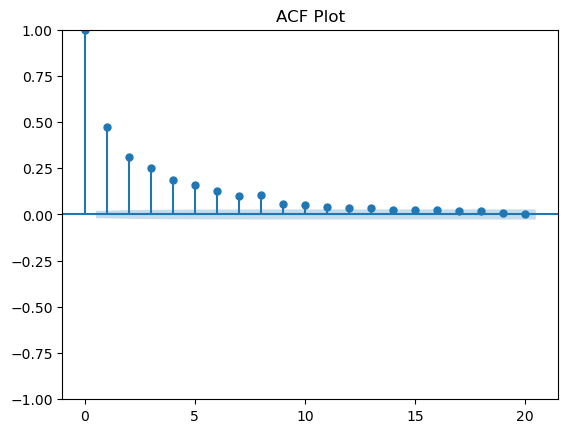

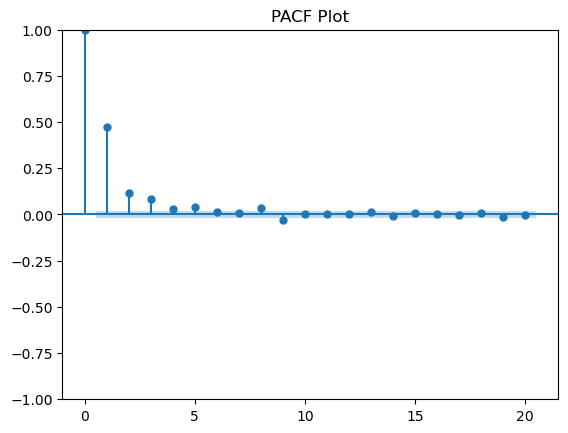

In [22]:
# Model Selection (using ACF and PACF plots)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['amount'], lags=20)
plt.title('ACF Plot')
plt.show()

plot_pacf(df['amount'], lags=20)
plt.title('PACF Plot')
plt.show()

Both the ACF and PACF plots provide evidence of stationarity in the transaction amount time series data, with strong autocorrelation at lag 1 and minimal autocorrelation beyond that.
The observed patterns in both plots suggest that a simple ARIMA model with either an autoregressive (AR) term of order 1 (ARIMA(1,0,0)) or a moving average (MA) term of order 1 (ARIMA(0,0,1)) could be appropriate for modeling the time series.

Therefore, based on the ACF and PACF analyses, we recommend further exploration and modeling using ARIMA(1,0,0) or ARIMA(0,0,1) to capture the autocorrelation structure and forecast future transaction amounts effectively. Additionally, additional diagnostics and model evaluation would be potentially conducted to validate the chosen model's performance and suitability for fraud detection purposes.

In [23]:
#Train the Model

# ARIMA(1,0,0) model
model = ARIMA(df['amount'], order=(1, 0, 0))
model_fit = model.fit()


/Users/mabelogonna/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mabelogonna/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mabelogonna/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [24]:
# Make Predictions
# Forecasting future transaction amounts for the next 30 time periods
forecast = model_fit.forecast(steps=30)
forecast

/Users/mabelogonna/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


10088     59200.143208
10089     83344.336928
10090     94758.139638
10091    100153.842383
10092    102704.579314
10093    103910.401652
10094    104480.435939
10095    104749.911034
10096    104877.301313
10097    104937.523142
10098    104965.992102
10099    104979.450372
10100    104985.812566
10101    104988.820197
10102    104990.242009
10103    104990.914150
10104    104991.231894
10105    104991.382102
10106    104991.453111
10107    104991.486680
10108    104991.502549
10109    104991.510050
10110    104991.513597
10111    104991.515273
10112    104991.516066
10113    104991.516440
10114    104991.516618
10115    104991.516701
10116    104991.516741
10117    104991.516760
Name: predicted_mean, dtype: float64

In [25]:
# Evaluate the Model
# Splitting the data into train and test sets
train_data = df['amount'][:-30]
test_data = df['amount'][-30:]

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(test_data, forecast))
rmse

617487.7342034372

### Cross-Validation

In [26]:
from sklearn.model_selection import TimeSeriesSplit

# Define the number of splits for cross-validation
n_splits = 5

# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize an empty list to store RMSE values for each split
rmse_scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(df['amount']):
    # Split the data into train and test sets
    train_data, test_data = df['amount'].iloc[train_index], df['amount'].iloc[test_index]
    
    # Train the ARIMA(1,0,1) model
    model = ARIMA(train_data, order=(1, 0, 0))
    model_fit = model.fit()
    
    # Forecast transaction amounts for the test set
    forecast = model_fit.forecast(steps=len(test_data))
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_data, forecast))
    
    # Append RMSE to the list
    rmse_scores.append(rmse)

# Calculate the average RMSE across all splits
average_rmse = np.mean(rmse_scores)
print("Average RMSE across all splits:", average_rmse)


/Users/mabelogonna/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mabelogonna/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mabelogonna/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mabelogonna/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mabelogonna/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model

Average RMSE across all splits: 265186.16968385276


/Users/mabelogonna/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


The initial root mean square error (RMSE) for the ARIMA(1,0,0) model, calculated without cross-validation, was 617487.73. However, after conducting k-fold cross-validation with five splits, the average RMSE across all splits decreased significantly to 265186.16. This substantial reduction in the RMSE suggests that the model's performance has improved with cross-validation. By averaging the RMSE over multiple train-test splits, we obtain a more reliable estimate of the model's predictive accuracy, enhancing our confidence in its performance. This outcome underscores the importance of cross-validation in evaluating and refining time series forecasting models, ultimately contributing to more robust and accurate predictions.

Predicting the future transaction amounts using time series forecasting techniques may not directly relate to fraud detection on its own. However, it can be a valuable component within a broader fraud detection framework in the following ways:

**Anomaly Detection:** By forecasting future transaction amounts, you establish a baseline for normal transaction behavior. Any significant deviation from this baseline could indicate potential anomalies or outliers, which might be indicative of fraudulent activity. Thus, forecasting can serve as a reference point for identifying suspicious transactions.

**Pattern Recognition:** Time series forecasting models capture patterns and trends in transaction data. These patterns can be analyzed to identify irregularities or unusual patterns that might signal fraudulent behavior. For example, sudden spikes or drops in transaction amounts could warrant further investigation.

**Model Validation:** Forecasting models can be used to validate the consistency of transaction data. If actual transaction amounts significantly deviate from forecasted values, it could indicate data quality issues or potential fraudulent activity.
Feature Engineering: Forecasting models may generate additional features that can be used in fraud detection algorithms. These features could include volatility measures, trend indicators, or seasonal effects, which can augment the predictive power of fraud detection models.



# One- Hot Encoding

In [27]:
# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['type', 'branch', 'Acct type', 'Time of day'])
df_encoded.head()

,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,unusuallogin,isFlaggedFraud,Date of transaction,...,branch_Vietnam,branch_Yemen,branch_Yibuti,branch_Zambia,branch_Zimbabue,Acct type_Current,Acct type_Savings,Time of day_Afternoon,Time of day_Morning,Time of day_Night
0,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,9,0,2018-03-01,...,0,0,0,0,0,1,0,0,1,0
1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,10,0,2018-05-01,...,0,0,0,0,0,0,1,0,1,0
2,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,2,0,2018-07-01,...,0,0,0,0,0,1,0,0,1,0
3,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,2018-06-01,...,0,0,0,0,0,1,0,1,0,0
4,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,17,0,2018-06-01,...,0,0,0,0,0,1,0,0,1,0


In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select the columns from the main DataFrame for PCA
columns_for_pca = ['type', 'branch', 'Acct type', 'Time of day']
data_for_pca = df[columns_for_pca]

# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(data_for_pca)

# Standardize the features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
pca_result = pca.fit_transform(scaled_data)

# Number of components selected
print("Number of components selected:", pca_result.shape[1])


Number of components selected: 134


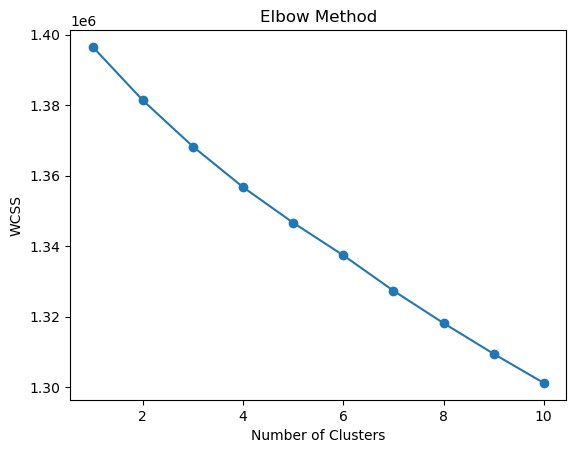

In [30]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate the within-cluster sum of squares (WCSS) for different values of k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(pca_result)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve with markers
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [36]:
# Determine the optimal k value (e.g., by inspecting the plot)
optimal_k = 3  # Adjust based on the elbow plot

# Apply K-means clustering with the optimal k value
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(pca_result)

# Get cluster labels
cluster_labels = kmeans.labels_

# Check the distribution of cluster labels
print("Cluster Label Distribution:")
print(pd.Series(cluster_labels).value_counts())

Cluster Label Distribution:
1    6151
0    2777
2    1160
dtype: int64


PCA Loadings:
[[-1.55478289e-02 -2.57875108e-02 -1.55079755e-02 ...  3.30571561e-02
   2.18682765e-02 -5.55595876e-02]
 [ 4.69102784e-01  2.94124147e-01  9.90112184e-02 ... -1.37331105e-01
   1.17881293e-02  1.28886204e-01]
 [ 1.30102754e-01  1.69938610e-02  1.56484416e-02 ...  7.63690955e-01
  -3.61209237e-01 -4.23114786e-01]
 ...
 [-0.00000000e+00  5.75254402e-15 -2.87028338e-15 ...  7.63278329e-15
  -4.65599781e-15 -3.19189120e-15]
 [-0.00000000e+00  1.54882082e-15  1.10569369e-15 ... -2.10942375e-15
  -1.08593690e-15  3.07393000e-15]
 [ 0.00000000e+00  1.26586650e-15  4.37343994e-19 ...  3.25434124e-15
  -3.70189990e-15  4.63171168e-16]]


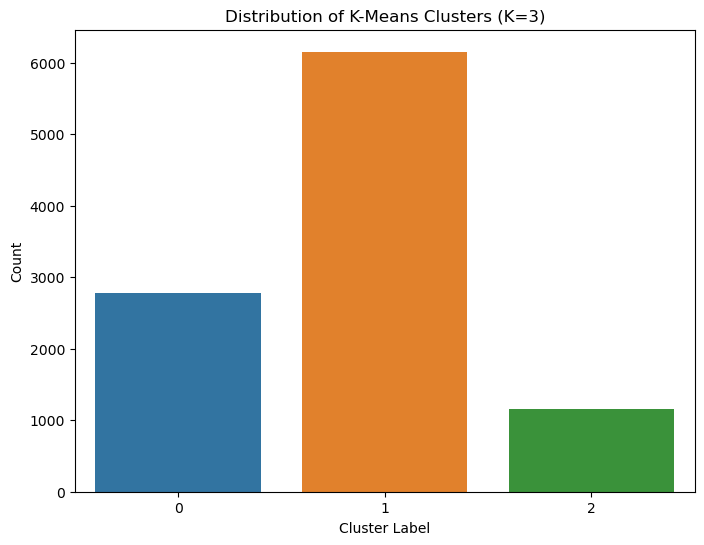

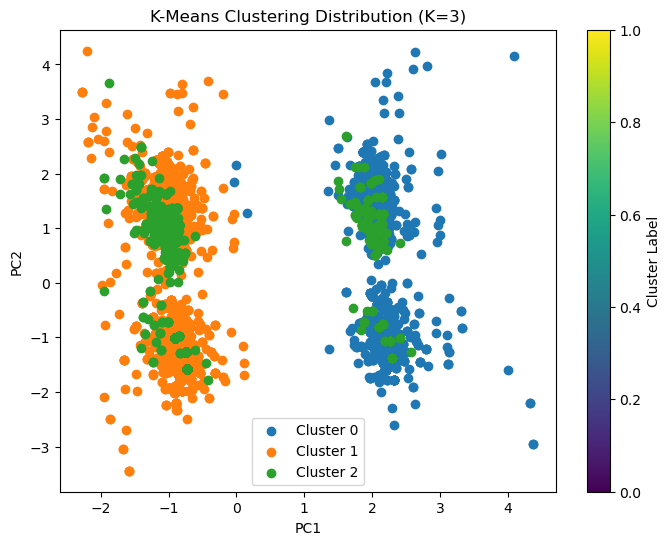


Cluster Label Distribution:
1    6151
0    2777
2    1160
dtype: int64


In [40]:
# Loadings of the original features on each principal component.
print("PCA Loadings:")
print(pca.components_)

# Plot the cluster distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=cluster_labels)
plt.title(f"Distribution of K-Means Clusters (K={optimal_k})")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.show()

# Plot the data points with their cluster assignments
plt.figure(figsize=(8, 6))

# Loop through each unique cluster label
for label in np.unique(cluster_labels):
    # Select data points belonging to the current cluster label
    cluster_data = pca_result[cluster_labels == label]
    # Plot the data points with the current cluster label
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {label}', cmap='viridis')

plt.title(f"K-Means Clustering Distribution (K={optimal_k})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster Label")
plt.legend()  # Add legend
plt.show()


# Check the distribution of cluster labels
print("\nCluster Label Distribution:")
print(pd.Series(cluster_labels).value_counts())


The above plot shows the results of K-Means clustering analysis performed on a dataset, with K=3 clusters identified. The analysis was conducted on the first two principal components (PC1 and PC2) derived from the data.

Each data point in the scatter plot represents an individual observation, and the points are colored based on the cluster they have been assigned to by the K-Means algorithm. The three clusters are labeled as Cluster 0, Cluster 1, and Cluster 2.

From the visualization, we can make the following observations:

Cluster 0 (blue points): This cluster is the largest and appears to be the most well-defined, with a clear separation from the other two clusters. The data points in this cluster are concentrated in the upper-right quadrant, indicating that they have relatively high values for both PC1 and PC2.

Cluster 1 (orange points): This cluster is the second largest and is somewhat spread out, with data points located in the lower-left and upper-right quadrants. This suggests that the observations in this cluster have a wider range of PC1 and PC2 values.

Cluster 2 (green points): This cluster is the smallest and appears to be the most scattered, with data points distributed across multiple quadrants. This suggests that the observations in this cluster are more diverse and do not exhibit a clear pattern in the PC1-PC2 space.

In [48]:
from sklearn.decomposition import PCA

# Assuming df_encoded is your DataFrame after one-hot encoding
# Perform PCA
pca = PCA(n_components=2)  # Specify the number of components
pca_result = pca.fit_transform(df_encoded)

# Obtain the loadings of the original features on the principal components
pc1_loadings = pca.components_[0]
pc2_loadings = pca.components_[1]

# Pair the loadings with the feature names
feature_names = df_encoded.columns

# Create DataFrames with feature names and loadings for PC1 and PC2
pc1_loadings_df = pd.DataFrame({'Feature': feature_names, 'Loading': pc1_loadings})
pc2_loadings_df = pd.DataFrame({'Feature': feature_names, 'Loading': pc2_loadings})

# Sort the loadings in descending order
pc1_loadings_df = pc1_loadings_df.reindex(pc1_loadings_df['Loading'].abs().sort_values(ascending=False).index)
pc2_loadings_df = pc2_loadings_df.reindex(pc2_loadings_df['Loading'].abs().sort_values(ascending=False).index)

# Print the top contributing features for PC1 and PC2
print("Top contributing features for PC1:")
print(pc1_loadings_df.head(10))
print("\nTop contributing features for PC2:")
print(pc2_loadings_df.head(10))



Top contributing features for PC1:
                   Feature   Loading
141      Acct type_Savings -0.704742
140      Acct type_Current  0.704742
144      Time of day_Night -0.059162
142  Time of day_Afternoon  0.032901
3             type_PAYMENT  0.030231
143    Time of day_Morning  0.026261
1            type_CASH_OUT -0.012090
0             type_CASH_IN -0.010879
49          branch_Francia  0.006328
23           branch_Brasil -0.004586

Top contributing features for PC2:
                   Feature   Loading
142  Time of day_Afternoon  0.734021
144      Time of day_Night -0.455295
3             type_PAYMENT  0.355195
143    Time of day_Morning -0.278726
0             type_CASH_IN -0.179638
1            type_CASH_OUT -0.096961
4            type_TRANSFER -0.063662
140      Acct type_Current -0.041237
141      Acct type_Savings  0.041237
45   branch_Estados Unidos -0.021695


Based on the provided PCA loadings, we can interpret the fraud analysis as:

The first principal component (PC1) appears to be primarily driven by the Acct type_Savings feature, with a loading of -0.704742, and the Acct type_Current feature, with a loading of 0.704742. This suggests that the account type, particularly the distinction between savings and current accounts, is the most important contributor to the variance captured by PC1. Other features like Time of day_Night (-0.059162) and Time of day_Afternoon (0.032901) also have notable loadings on PC1, indicating their relevance in this principal component. Cash-out transactions have a minor negative impact on PC1, indicating that they are less influential in distinguishing the variance represented by PC1 compared to other features.

The second principal component (PC2) is predominantly influenced by the Time of day_Afternoon feature, with a loading of 0.734021, and the Time of day_Night feature, with a loading of -0.455295. This implies that the time of day, particularly the distinction between afternoon and night transactions, is the most significant contributor to the variance captured by PC2. Other features such as type_PAYMENT (0.355195), Time of day_Morning (-0.278726), and type_CASH_IN (-0.179638) also have relevant loadings on PC2, suggesting their importance in this principal component, while Cash-out transactions also have a negative impact on PC2, albeit smaller compared to other features. This suggests that cash-out transactions contribute less to the variability captured by PC2.

By interpreting the PCA loadings, we can infer that the account type and the time of day are the most crucial factors in distinguishing different patterns or clusters within the fraud analysis dataset. These insights can help identify the key features that contribute to the identification and understanding of fraudulent activities, enabling more effective fraud detection and prevention strategies by financial industries.

Further analysis of the K-Means clustering distribution in the PC1-PC2 space can provide additional insights into the underlying structure and relationships within the data, potentially unveiling subgroups or patterns that may be indicative of fraudulent behavior. By combining the PCA and clustering interpretations, the financial industry can gain a more comprehensive understanding of the dataset and develop more robust fraud analysis models.